# Model Quality Monitoring
In this noteboook, we set up monitors to check various quality metrics of the model.
The steps are given below:
1. Enable data capture on the endpoint
2. Prepare baseline dataset (with labels)
3. Create baseline statistics & constraints
4. Setup continous monitoring with a Model Quality Monitor
5. Schedule monitoring jobs
6. Set up CloudWatch alerts

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [2]:
import logging

# Only show warnings or abovee
logging.basicConfig(level=logging.WARNING)

logging.getLogger("sagemaker").setLevel(logging.WARNING)
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)
logging.getLogger("sagemaker.session").setLevel(logging.WARNING)

## Enable Data Capture On the Endpoint

In [3]:
model_package_arn = 'arn:aws:sagemaker:us-east-2:657480822269:model-package/disease-classification-model-01012026/9'

In [4]:
role = sagemaker.get_execution_role()

In [5]:
bucket = "disease-classification-12052025"

**Adding inference.py to model package**:
Our XGBoost model returns a float value instead of an integer (Ex: 29.0 instead of 29). Thus, we need to add a postprocessing step before the model is deployed and monitored by the Model Quality Monitor. Otherwise, the monitor would consider that the prediction is not matching with the ground truth.

These changes are done in the following cells and the new model package is deployed with data capture enabled.

In [6]:
model = sagemaker.ModelPackage(role=role, 
                     model_package_arn=model_package_arn, 
                     sagemaker_session=sagemaker.Session())

In [7]:
sm = boto3.client("sagemaker")
desc = sm.describe_model_package(
    ModelPackageName=model_package_arn
)
model_data = desc["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]
print(model_data)

s3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/output/model.tar.gz


In [8]:
from sagemaker.xgboost import XGBoostModel

session = sagemaker.Session()

xgb_model = XGBoostModel(
    model_data=model_data,                 # ← reused artifact
    role=role,
    entry_point="inference.py",             # ← NEW
    framework_version="1.7-1",
    py_version="py3",
    sagemaker_session=session
)

In [9]:
model_package_group_name = "disease-classification-model-01012026"
model_package = xgb_model.register(
    model_package_group_name=model_package_group_name,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.m4.xlarge"],
    transform_instances=["ml.m4.xlarge"],
    approval_status="Approved"   
)

In [10]:
model_package.model_package_arn

'arn:aws:sagemaker:us-east-2:657480822269:model-package/disease-classification-model-01012026/15'

In [11]:
model = sagemaker.ModelPackage(role=role, 
                     model_package_arn=model_package.model_package_arn, 
                     sagemaker_session=sagemaker.Session())

In [12]:
from sagemaker.model_monitor import DataCaptureConfig

s3_capture_upload_path= f"s3://{bucket}/data-capture/"
endpoint_name = "disease-classification-model-04-01-2025"
print("EndpointName = {}".format(endpoint_name))

data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

EndpointName = disease-classification-model-04-01-2025
-------!

In [14]:
predictor = sagemaker.Predictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker.Session())

In [15]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set serializer/deserializer for CSV input and JSON output
predictor.serializer = CSVSerializer()
#predictor.deserializer = JSONDeserializer()

Now, the endpoint is ready with data capture enabled in it. The requests to the endpoint and the predictions made by model will be stored in the specified path in S3.

## Baseline Dataset
This dataset will be later used to create the baseline statistics and constraints. In this section, we will invoke the endpoint created above using validation data. Predictions from the deployed model using this validation data will be used as a baseline dataset.

In [16]:
val_file_path = f"s3://{bucket}/data/val.csv"

In [17]:
val_df = pd.read_csv(val_file_path)
val_df.shape

(983, 133)

In [18]:
baseline_file_name = 'baseline_dataset.csv'

In [19]:
limit = 200  # Need at least 200 samples to compute standard deviations
features_for_inference = val_df.iloc[0:limit,1:].values.tolist()
csv_rows = [",".join(map(str, row)) for row in features_for_inference]

ground_truth_labels = val_df.iloc[0:limit,0]

i=0
with open(f"{baseline_file_name}", "w") as baseline_file:
    baseline_file.write("prediction,label\n")  # header
    for row in csv_rows:
        prediction_result = predictor.predict(row)
        prediction = int(float(prediction_result.strip().decode('utf-8'))) #int(prediction_result['predictions'][0]['score'])
        label = ground_truth_labels[i]
        baseline_file.write(f"{prediction},{label}\n")
        i=i+1
           
print("Done!")

Done!


In [20]:
# Upload baseline file to S3
s3 = boto3.client('s3')
s3.upload_file(baseline_file_name, bucket, f'data/{baseline_file_name}')

## Baseline Statistics and Constraints

In [21]:
baseline_file_path_s3 = f"s3://{bucket}/data/{baseline_file_name}"
baseline_df = pd.read_csv(baseline_file_path_s3)

In [22]:
baseline_df.head()

,prediction,label
0,23,23
1,10,10
2,22,22
3,40,40
4,28,28


In [23]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [24]:
# Set up model quality monitor
disease_classification_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sagemaker.Session(),
)

In [25]:
from datetime import datetime
baseline_job_name = f"disease-classification-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"
baseline_results_uri = f"s3://{bucket}/baseline-results/"

In [26]:
# Set up baselining job
job = disease_classification_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_file_path_s3,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="MulticlassClassification",
    inference_attribute="prediction",
    ground_truth_attribute="label",
)
job.wait(logs=False)

...........................................................!

The baseline constraints and statistics generated has been uploaded to S3.

### View the metrics generated

In [27]:
baseline_job = disease_classification_quality_monitor.latest_baselining_job
baseline_metrics = baseline_job.baseline_statistics().body_dict["multiclass_classification_metrics"]
pd.json_normalize(baseline_metrics).T

,0
confusion_matrix.34.34,7.000000
confusion_matrix.34.12,0.000000
confusion_matrix.34.8,0.000000
confusion_matrix.34.19,0.000000
confusion_matrix.34.23,0.000000
...,...
weighted_f0_5_best_constant_classifier.standard_deviation,0.001089
weighted_f1_best_constant_classifier.value,0.004762
weighted_f1_best_constant_classifier.standard_deviation,0.001647
weighted_f2_best_constant_classifier.value,0.010417


### View the constraints generated

In [28]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["multiclass_classification_constraints"]).T

,threshold,comparison_operator
accuracy,1.0,LessThanThreshold
weighted_recall,1.0,LessThanThreshold
weighted_precision,1.0,LessThanThreshold
weighted_f0_5,1.0,LessThanThreshold
weighted_f1,1.0,LessThanThreshold
weighted_f2,1.0,LessThanThreshold


We can see that model quality monitor suggested a constraint that will ensure that the model accuracy, weighted recall, weighted precision and weighted F1 score should be lesser than 1. This will be always true. Hence, we need to update the constraints

In [29]:
import json

# Copy constraints file from S3
!aws s3 cp s3://disease-classification-12052025/baseline-results/constraints.json ./constraints.json

# Define a recursive function to update the threshold and comparison_operator
def update_constraints(obj):
    if isinstance(obj, dict):
        for key, value in obj.items():
            if key == "threshold":
                obj[key] = 0.97  # Change the threshold to 0.97
            elif key == "comparison_operator":
                obj[key] = "LessThanThreshold"  # Change the comparison_operator
            else:
                update_constraints(value)
    elif isinstance(obj, list):
        for item in obj:
            update_constraints(item)

# Load the JSON file
with open("constraints.json", "r") as json_file:
    data = json.load(json_file)

# Update the threshold and comparison_operator values
update_constraints(data)

# Save the updated JSON back to the file
with open("constraints.json", "w") as json_file:
    json.dump(data, json_file, indent=4)

download: s3://disease-classification-12052025/baseline-results/constraints.json to ./constraints.json


In [30]:
# Copy the modified constraints file to S3
!aws s3 cp ./constraints.json s3://disease-classification-12052025/baseline-results/constraints.json

upload: ./constraints.json to s3://disease-classification-12052025/baseline-results/constraints.json


In [31]:
# View the modified constraints
pd.DataFrame(baseline_job.suggested_constraints().body_dict["multiclass_classification_constraints"]).T

,threshold,comparison_operator
accuracy,0.97,LessThanThreshold
weighted_recall,0.97,LessThanThreshold
weighted_precision,0.97,LessThanThreshold
weighted_f0_5,0.97,LessThanThreshold
weighted_f1,0.97,LessThanThreshold
weighted_f2,0.97,LessThanThreshold


## Setup continuous model monitoring to identify model quality drift
In this section, we will setup a continuous model monitoring job that monitors the quality of the deployed model against the baseline generated in the previous section. This is to ensure that the quality does not degrade over time.

In addition to the generated baseline, Amazon SageMaker Model Quality Monitoring needs two additional inputs - predictions made by the deployed model endpoint and the ground truth data to be provided by the model consuming application. Since we already enabled data capture on the endpoint, prediction data is captured in S3. In this project, we will use the test dataset for creating artificial traffic to the endpoint and also upload the ground truth labels from the dataset for monitoring purpose.

### Generate prediction data for Model Quality Monitoring
In this section, we start a thread to send some artificial traffic to the endpoint. If there is no traffic, the monitoring jobs are marked as Failed since there is no data to process.

In [32]:
import threading
from time import sleep

In [33]:
tmp_df = pd.read_csv('test.csv', header=None)
tmp_df = tmp_df.iloc[:,1:]
tmp_df.to_csv("test_file_no_target_for_monitor.csv", index=False, header=False)

In [34]:
!aws s3 cp ./test_file_no_target_for_monitor.csv s3://disease-classification-12052025/data/test_file_no_target_for_monitor.csv

upload: ./test_file_no_target_for_monitor.csv to s3://disease-classification-12052025/data/test_file_no_target_for_monitor.csv


In [35]:
def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = sagemaker.Session().sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "test_file_no_target_for_monitor.csv")
        except sagemaker.Session().sagemaker_runtime_client.exceptions.ValidationError:
            pass

thread = threading.Thread(target=invoke_endpoint_forever)
thread.start()

### Generate synthetic ground truth data
In this section, we start generating synthetic ground truth data using the test dataset. The model quality job will fail if there's no ground truth data to merge.

In [36]:
ground_truth_upload_path = f"s3://{bucket}/ground_truth_traffic"

def ground_truth_with_id(inference_id, val):
    return {
        "groundTruthData": {
            "data": f"{val}", 
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [37]:
from sagemaker.s3 import S3Downloader, S3Uploader

In [38]:
NUM_GROUND_TRUTH_RECORDS = 41  

test_data = pd.read_csv('test.csv', header=None)
target_truth = test_data.iloc[:, 0]

def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i, target_truth.iloc[i]) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = threading.Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 41 records to s3://disease-classification-12052025/ground_truth_traffic/2026/01/07/03/0158.jsonl


### Create a monitoring schedule
Now that we have the baseline information and ground truth labels, we can create a monitoring schedule to run model quality monitoring job.

In [39]:
disease_classification_monitor_schedule_name = (
    f"disease-classification-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [40]:
from sagemaker.model_monitor import EndpointInput

In [41]:
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    inference_attribute="0",
    destination="/opt/ml/processing/input_data",
)

In [42]:
# Create the monitoring schedule to execute every hour.
from sagemaker.model_monitor import CronExpressionGenerator

s3_uri_monitoring_output = f"s3://{bucket}/modelmonitor"
response = disease_classification_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=disease_classification_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=s3_uri_monitoring_output,
    problem_type="MulticlassClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

In [43]:
disease_classification_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-2:657480822269:monitoring-schedule/disease-classification-monitoring-schedule-2026-01-07-0301',
 'MonitoringScheduleName': 'disease-classification-monitoring-schedule-2026-01-07-0301',
 'MonitoringScheduleStatus': 'Pending',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2026, 1, 7, 3, 2, 0, 794000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2026, 1, 7, 3, 2, 0, 861000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2026-01-07-03-01-59-884',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'disease-classification-model-04-01-2025',
 'ResponseMetadata': {'RequestId': '86028e83-4824-4f96-b47c-2f1379a580ff',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '86028e83-4824-4f96-b47c-2f1379a580ff',
   'strict-transport-security': 'max-age=47304000; includeSu

### Examine the monitoring schedule executions

In [44]:
executions = disease_classification_quality_monitor.list_executions()

In [45]:
executions

[]

No executions found for the monitoring schedule.

In [46]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = disease_classification_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution...................................................................................................................................................................................................................................................................................................................................................................Uploading 41 records to s3://disease-classification-12052025/ground_truth_traffic/2026/01/07/04/0201.jsonl
......................
Execution found!


In [47]:
while not executions:
    executions = disease_classification_quality_monitor.list_executions()
    print(".", end="", flush=True)
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

.

{'ProcessingInputs': [{'InputName': 'groundtruth_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://disease-classification-12052025/ground_truth_traffic/2026/01/07/03',
    'LocalPath': '/opt/ml/processing/groundtruth/2026/01/07/03',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://disease-classification-12052025/data-capture/disease-classification-model-04-01-2025/AllTraffic/2026/01/07/03',
    'LocalPath': '/opt/ml/processing/input_data/disease-classification-model-04-01-2025/AllTraffic/2026/01/07/03',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://disease-classification-12052025/modelmonitor/merge',
   

#### Inspect a specific execution (latest execution)
In a previous section, we picked up the latest completed or failed scheduled execution. Here are the possible terminal states and what each of them mean:

1. Completed - This means the monitoring execution completed and no issues were found in the violations report.
2. CompletedWithViolations - This means the execution completed, but constraint violations were detected.
3. Failed - The monitoring execution failed, maybe due to client error (perhaps incorrect role permissions) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.
4. Stopped - job exceeded max runtime or was manually stopped

In [48]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = disease_classification_quality_monitor.list_executions()[-1]
    execution = disease_classification_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Waiting for execution to finish........................................................!
groundtruth-merge-202601070400-58f8b6a764ff331923207084 job status: Completed
groundtruth-merge-202601070400-58f8b6a764ff331923207084 job exit message, if any: None
groundtruth-merge-202601070400-58f8b6a764ff331923207084 job failure reason, if any: None
Waiting for execution to finish....................................................!
model-quality-monitoring-202601070400-58f8b6a764ff331923207084 job status: Completed
model-quality-monitoring-202601070400-58f8b6a764ff331923207084 job exit message, if any: Completed: Job completed successfully with no violations.
model-quality-monitoring-202601070400-58f8b6a764ff331923207084 job failure reason, if any: None
Execution status is: Completed


In [49]:
latest_execution = disease_classification_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

Report Uri: s3://disease-classification-12052025/modelmonitor/disease-classification-model-04-01-2025/disease-classification-monitoring-schedule-2026-01-07-0301/2026/01/07/04


#### View violations generated by monitoring schedule

In [50]:
pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)

""


Hence, there are no violations to the suggested constraints set based on the baseline data.

## Analyze model quality CloudWatch metrics
In addition to the violations, the monitoring schedule also emits CloudWatch metrics. In this section, we will view the metrics generated and setup a CloudWatch alarm to be triggered when the model quality drifts from the baseline thresholds. We could also use CloudWatch alarms to trigger remedial actions such as retraining your model or updating the training dataset.

###  List the CW metrics generated.

In [51]:
# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": disease_classification_monitor_schedule_name},
]

In [52]:
# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

weighted_recall
weighted_precision_best_constant_classifier
weighted_f2
weighted_f0_5_best_constant_classifier
weighted_f0_5
weighted_f1
weighted_recall_best_constant_classifier
accuracy_best_constant_classifier
weighted_precision
total_number_of_violations
weighted_f2_best_constant_classifier
weighted_f1_best_constant_classifier
accuracy


### Create CloudWatch Alarms
Based on the cloud watch metrics, we can create a cloud watch alarm when a specific metric does not meet the threshold configured. Here we will create an alarm if the accuracy or weighted recall of the model fall below the threshold suggested by the baseline constraints.

In [53]:
alarm_name = "MODEL_QUALITY_ACCURACY"
alarm_desc = (
    "Trigger an CloudWatch alarm when the accuracy score drifts away from the baseline constraints"
)
mdoel_quality_acc_drift_threshold = (
    0.80
)
metric_name = "accuracy"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": disease_classification_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=6,
    DatapointsToAlarm=3,
    Threshold=mdoel_quality_acc_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': '44a7cde3-0ce5-4b6e-bf8d-c89f87e4c04e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '44a7cde3-0ce5-4b6e-bf8d-c89f87e4c04e',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Wed, 07 Jan 2026 04:16:25 GMT'},
  'RetryAttempts': 0}}

In [54]:
alarm_name = "MODEL_QUALITY_WEIGHTED_RECALL"
alarm_desc = (
    "Trigger an CloudWatch alarm when the weighted recall score drifts away from the baseline constraints"
)
mdoel_quality_rec_drift_threshold = (
    0.80
)
metric_name = "weighted_recall"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": disease_classification_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=6,
    DatapointsToAlarm=3,
    Threshold=mdoel_quality_acc_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': '4d6a3884-d0c5-4f7f-917e-f5a05eba3a8d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4d6a3884-d0c5-4f7f-917e-f5a05eba3a8d',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Wed, 07 Jan 2026 04:16:25 GMT'},
  'RetryAttempts': 0}}

In [55]:
alarm_name = "MODEL_QUALITY_WEIGHTED_PRECISION"
alarm_desc = (
    "Trigger an CloudWatch alarm when the weighted precision score drifts away from the baseline constraints"
)
mdoel_quality_rec_drift_threshold = (
    0.80
)
metric_name = "weighted_precision"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": disease_classification_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=6,
    DatapointsToAlarm=3,
    Threshold=mdoel_quality_acc_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': '5167c473-0002-45c4-a055-392ff66a9bcb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5167c473-0002-45c4-a055-392ff66a9bcb',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Wed, 07 Jan 2026 04:16:25 GMT'},
  'RetryAttempts': 0}}

The cloudwatch alarms have been set. Few screenshots are given below:


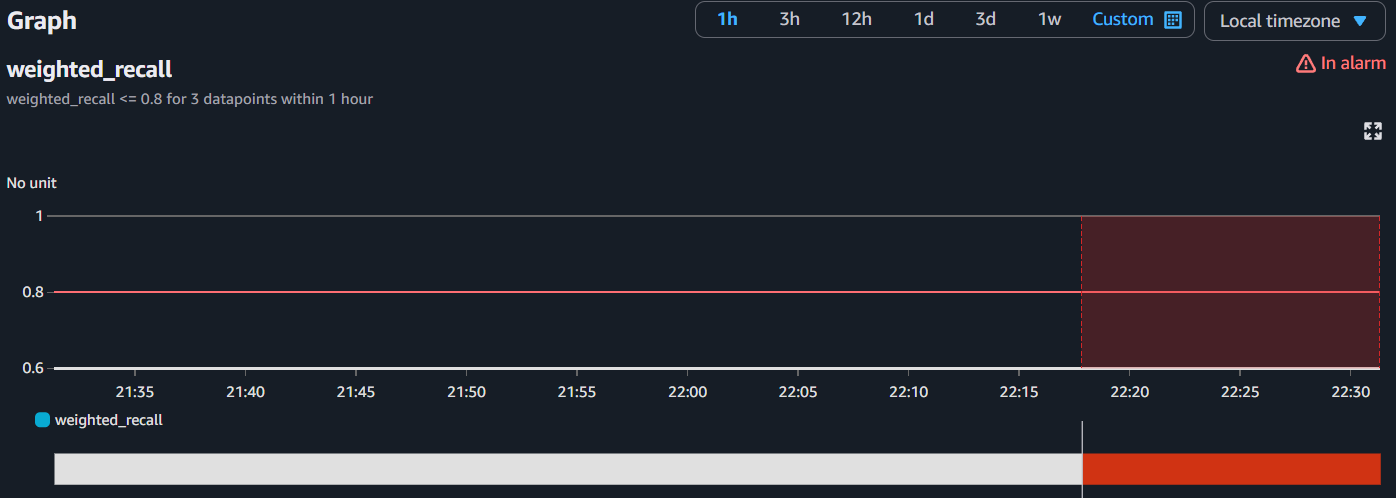
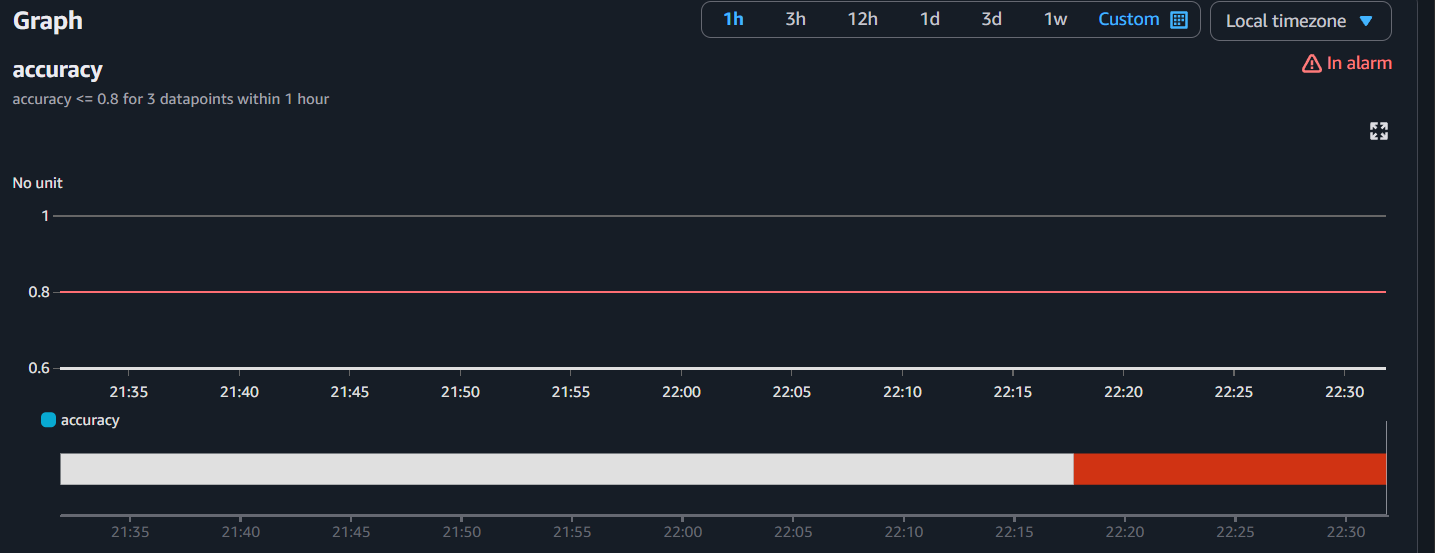
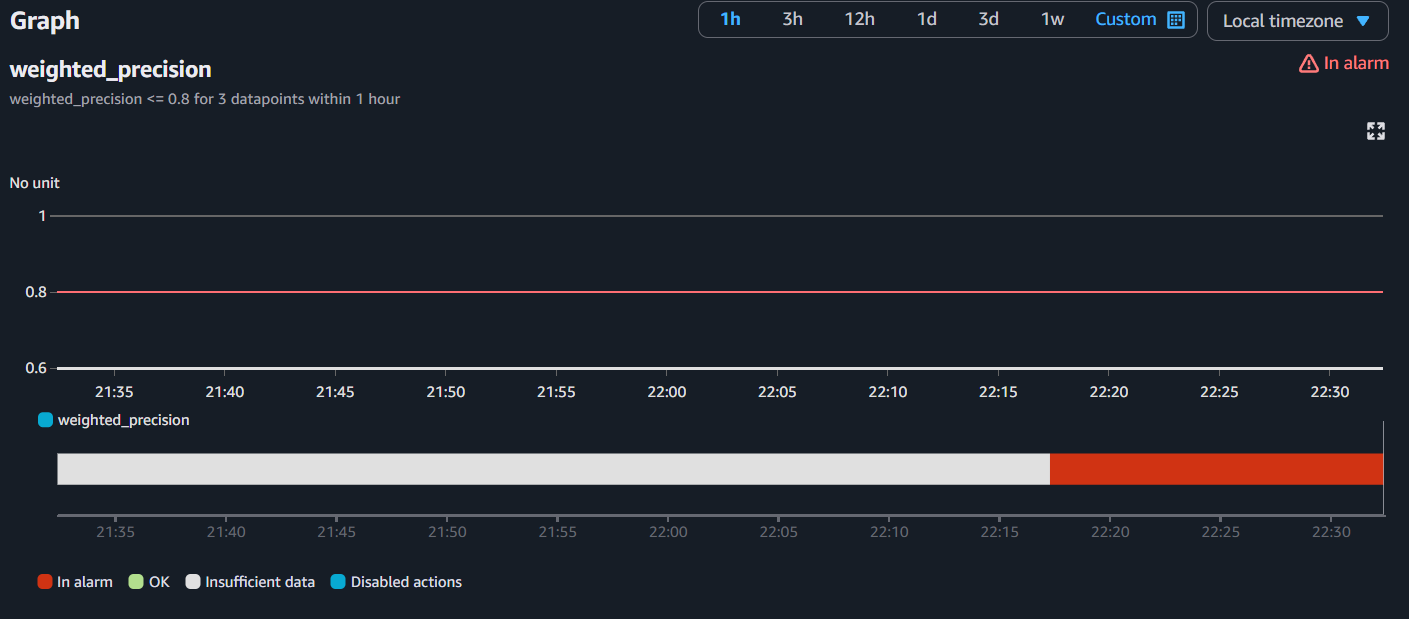


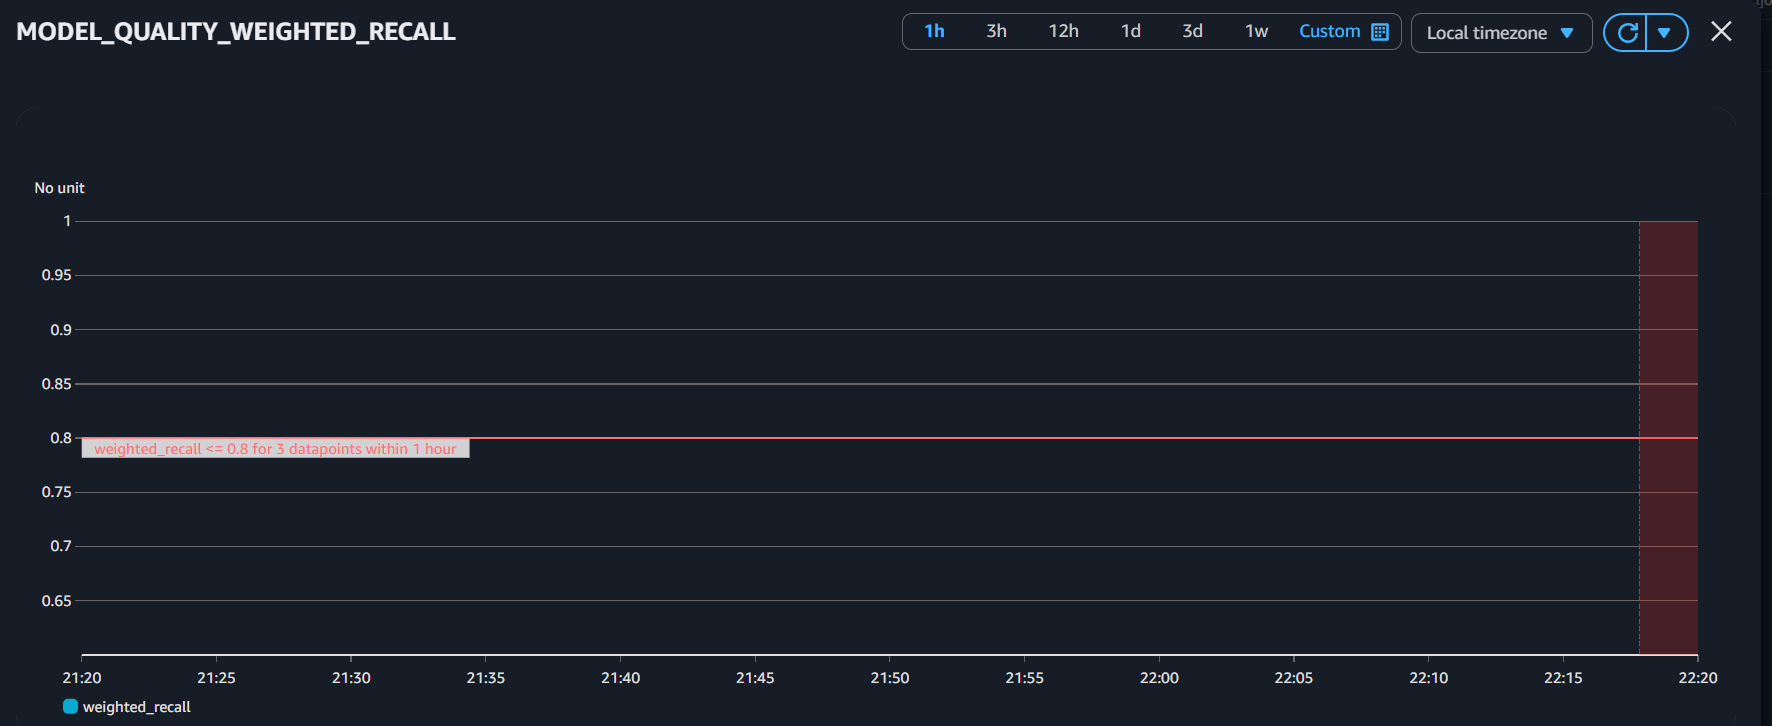

## Clean-up

In [57]:
# Delete monitoring schedules
sm = boto3.client("sagemaker")
response = sm.list_monitoring_schedules()
for sched in response["MonitoringScheduleSummaries"]:
    print(
        sched["MonitoringScheduleName"]
    )
    sm.delete_monitoring_schedule(
       MonitoringScheduleName=sched["MonitoringScheduleName"]
)

disease-classification-monitoring-schedule-2026-01-07-0301


In [58]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '65fff768-d77a-4d82-a925-c54d880063a4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '65fff768-d77a-4d82-a925-c54d880063a4',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 07 Jan 2026 04:36:29 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [60]:
#sm.delete_endpoint_config(EndpointConfigName=endpoint_name)